<h2 style='color:blue'>Dataset Preparation</h2>

In [3]:
import os
import numpy as np
import copy
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.metrics import accuracy_score
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import precision_score, recall_score, f1_score


# Constants
NUM_ATTR = 6
num_classes = [7, 3, 3, 4, 6, 3]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_epochs = 5
lr=0.0001
best_val_acc = 0
root_dir = '/kaggle/input/fashion-dataset-2024-term2/FashionDataset'
train_dir = os.path.join(root_dir, 'split/train.txt')
val_dir = os.path.join(root_dir, 'split/val.txt')
test_dir = os.path.join(root_dir, 'split/test.txt')
batch_size = 32
weight_decay = 1e-4  # L2 regularization



# Dataset class
class FashionNetDataset(Dataset):
    def __init__(self, root, txt, transform=None, test=False):
        self.img_path = []
        self.labels = None if test else []
        self.test = test  # Add a flag to indicate test mode
        self.transform = transform

        with open(txt) as f:
            for line in f:
                parts = line.strip().split()
                img_path = os.path.join(root, parts[0])
                self.img_path.append(img_path)
        if not test:
            label_path = txt.replace('.txt', '_attr.txt')
            if os.path.exists(label_path):
                with open(label_path) as lf:
                    for line in lf:
                        attrs = line.strip().split()
                        label = []
                        for i in range(NUM_ATTR):
                            label.append(int(attrs[i]))
                        self.labels.append(label)

        print(f"Processed {len(self.img_path)} images.")
    def __len__(self):

        return len(self.img_path)

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        if self.test:
            return img, torch.zeros(1, dtype=torch.long)  # Return a placeholder tensor for labels
        else:
            labels = torch.tensor(self.labels[index], dtype=torch.long)
            return img, labels

# Deal with class imbalance
    def get_class_weights(self):
        labels = []

        for i in range(len(self)):
            labels.append(self[i][1])

        labels = torch.stack(labels, dim=0)

        class_weights = []
        for i in range(labels.shape[1]):
            label = labels[:, i]
            unique_labels, counts = torch.unique(label, return_counts=True)
            weights = len(label) / (len(unique_labels) * counts.float())
            weights *= unique_labels.shape[0] / weights.sum()

            class_weights.append(weights)

        return class_weights

train_dataset = FashionNetDataset(root=root_dir, txt=train_dir)
val_dataset = FashionNetDataset(root=root_dir, txt=val_dir)
test_dataset = FashionNetDataset(root=root_dir, txt=test_dir, test=True)


Processed 5000 images.
Processed 1000 images.
Processed 1000 images.


<h2 style='color:blue'>Imbalanced Data</h2>

In [4]:
# Class names and count from your table, structured by category
class_names_by_category = [
    ['floral', 'graphic', 'striped', 'embroidered', 'pleated', 'solid', 'lattice'],  # Category 1
    ['long_sleeve', 'short_sleeve', 'sleeveless'],                                  # Category 2
    ['maxi_length', 'mini_length', 'no_dress'],                                      # Category 3
    ['crew_neckline', 'v_neckline', 'square_neckline', 'no_neckline'],               # Category 4
    ['denim', 'chiffon', 'cotton', 'leather', 'faux', 'knit'],                       # Category 5
    ['tight', 'loose', 'conventional']                                               # Category 6
]
# CALL get_class_weights
class_weights = train_dataset.get_class_weights()

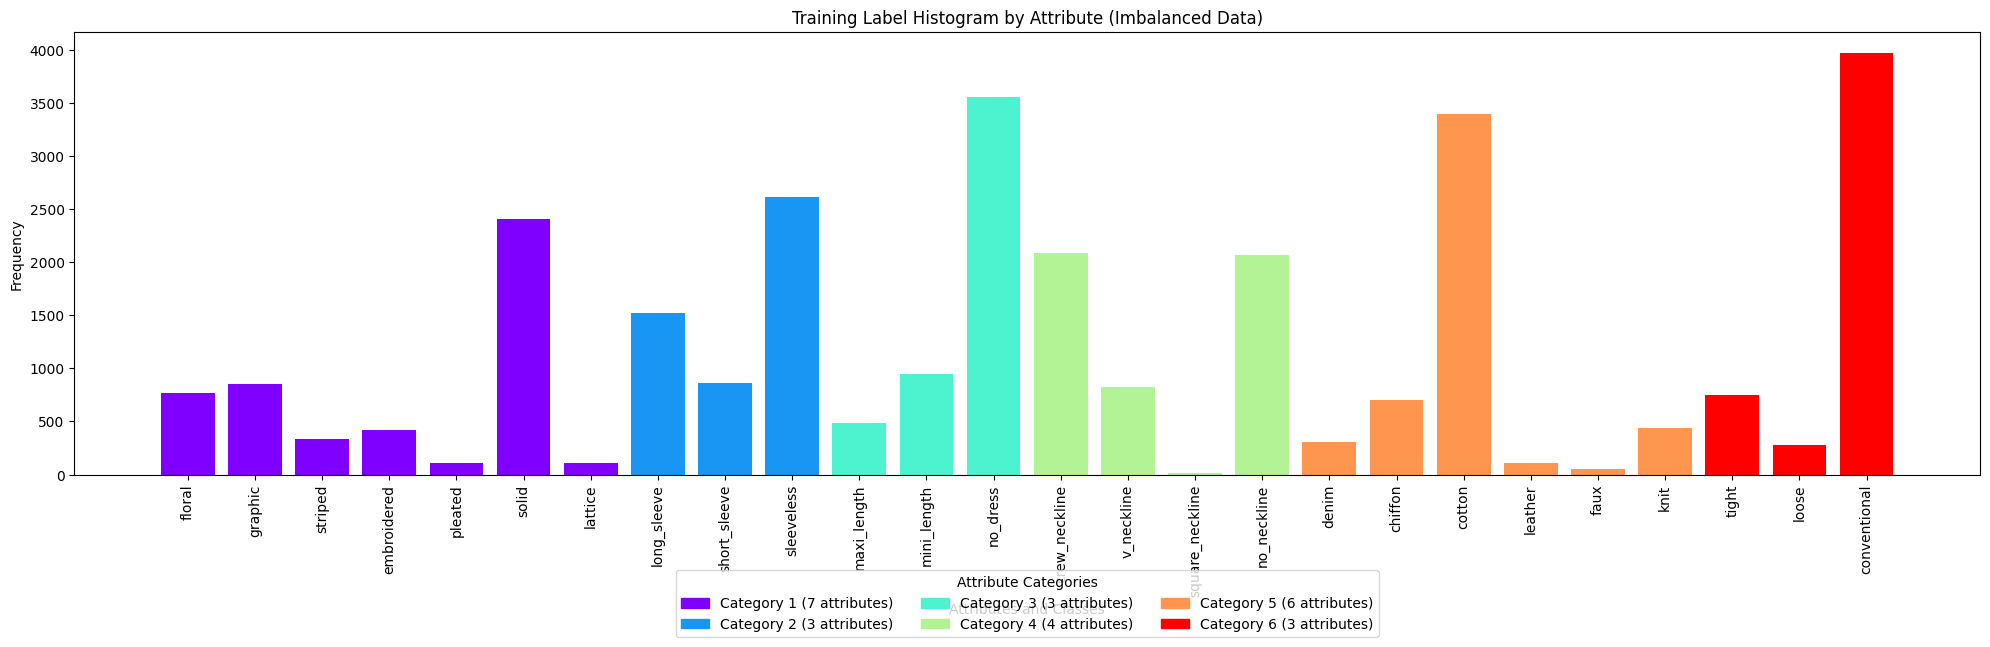

In [5]:
# Extract label information for all attributes
all_labels = np.array([train_dataset[i][1].numpy() for i in range(len(train_dataset))])

# Aggregate the counts for each attribute class
attribute_counts = np.zeros(sum(num_classes))
attribute_start_idx = [0] + list(np.cumsum(num_classes))

# Accumulate counts for each class in each attribute
for i in range(NUM_ATTR):
    attribute_values, counts = np.unique(all_labels[:, i], return_counts=True)
    start_idx = attribute_start_idx[i]
    for j, count in zip(attribute_values, counts):
        attribute_counts[start_idx + j] += count
# Create a mapping of actual attribute names with proper labeling
actual_class_names = [name for sublist in class_names_by_category for name in sublist]

# Define bar positions as an array from 0 to the number of attributes - 1
bar_positions = np.arange(len(attribute_counts))
# Generate the histogram plot for all attributes together with different colors for each bar
plt.figure(figsize=(20, 6))

# Assign colors for each attribute group
group_colors = plt.cm.rainbow(np.linspace(0, 1, NUM_ATTR))

# Create a mapping of actual attribute names with proper labeling
actual_class_names = [name for sublist in class_names_by_category for name in sublist]

# Create bars with different colors for each attribute category
start_idx = 0
for i, num_class in enumerate(num_classes):
    end_idx = start_idx + num_class
    plt.bar(bar_positions[start_idx:end_idx], attribute_counts[start_idx:end_idx], color=group_colors[i])
    start_idx = end_idx

# Customize x-axis labels to show actual attribute names
plt.xticks(bar_positions, actual_class_names, rotation=90)

# Create patches for the legend, indicating the category each color represents
legend_patches = [mpatches.Patch(color=group_colors[i], label=f'Category {i+1} ({len(class_names_by_category[i])} attributes)')
                  for i in range(NUM_ATTR)]

# Set the legend outside of the plot
plt.legend(handles=legend_patches, title='Attribute Categories', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

plt.title('Training Label Histogram by Attribute (Imbalanced Data)')
plt.ylabel('Frequency')
plt.xlabel('Attributes and Classes')
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.subplots_adjust(bottom=0.2)  # Increase the bottom margin to make space for the legend
plt.show()


<h2 style='color:blue'>Balanced Data</h2>

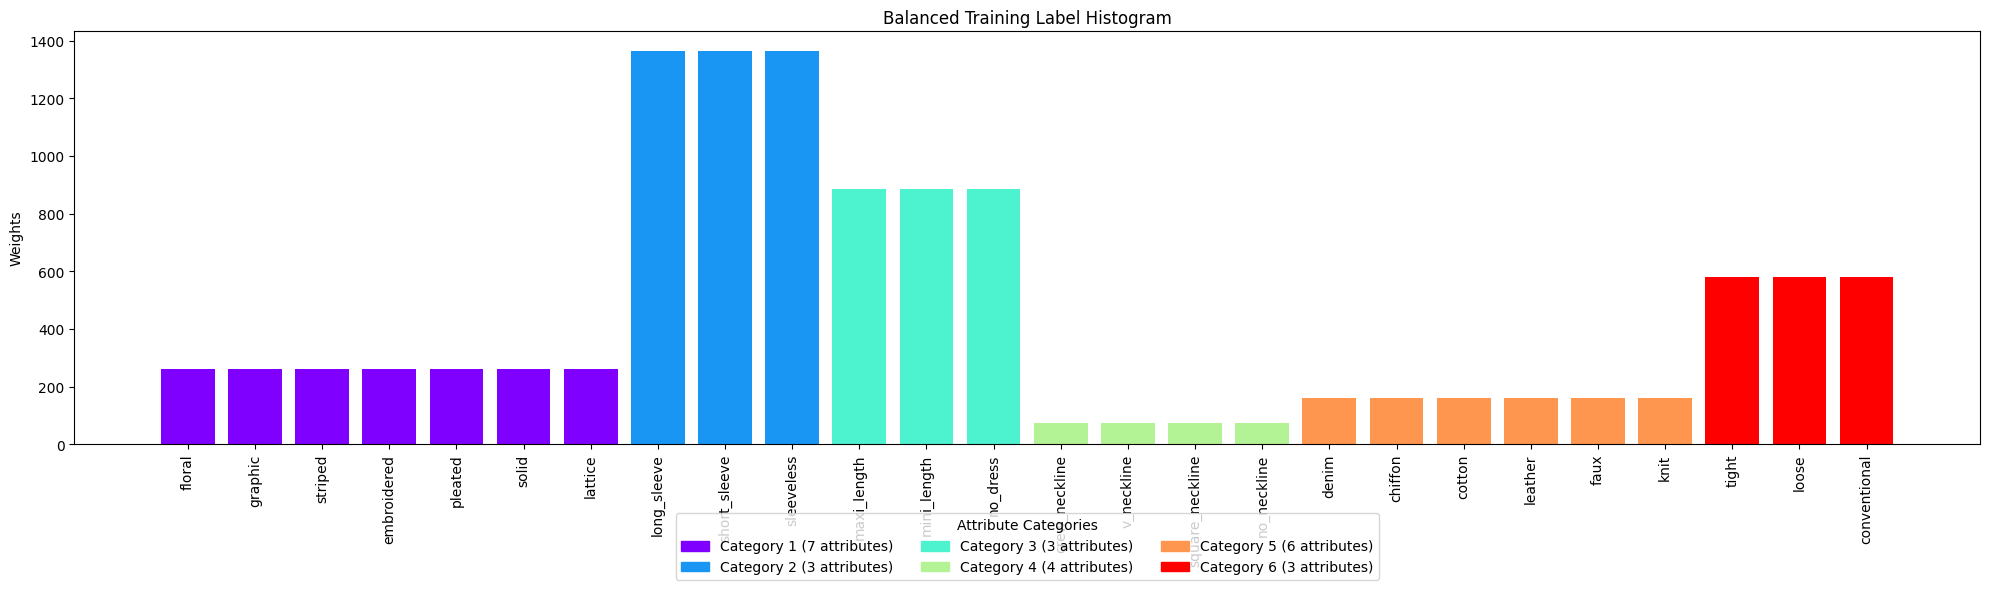

In [6]:

# Initialize weighted counts array
weighted_counts = np.zeros(sum(num_classes))

# Loop over each attribute and apply weights to the counts
for attr_idx in range(NUM_ATTR):
    attr_labels = all_labels[:, attr_idx]
    unique, counts = np.unique(attr_labels, return_counts=True)
    weights = class_weights[attr_idx].numpy()  # Assuming class_weights are already normalized and in the same order as unique
    for i, class_idx in enumerate(unique):
        class_labels = attr_labels == class_idx
        # Multiply counts by the corresponding weight and sum to get the weighted frequency
        weighted_counts[attribute_start_idx[attr_idx] + class_idx] = counts[i] * weights[class_idx]
        
# Define category_colors using group_colors
category_colors = []
for i, num_class in enumerate(num_classes):
    category_colors.extend([group_colors[i]] * num_class)        
# For balanced data
plt.figure(figsize=(20, 6))

# Use the same category colors for consistency
plt.bar(range(len(weighted_counts)), weighted_counts, color=category_colors)
plt.xticks(range(len(actual_class_names)), actual_class_names, rotation=90)

plt.title('Balanced Training Label Histogram')
plt.ylabel('Weights')

# Reuse the legend patches created earlier
plt.legend(handles=legend_patches, title='Attribute Categories', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.show()


<h2 style='color:blue'>Plot before Transformation</h2>

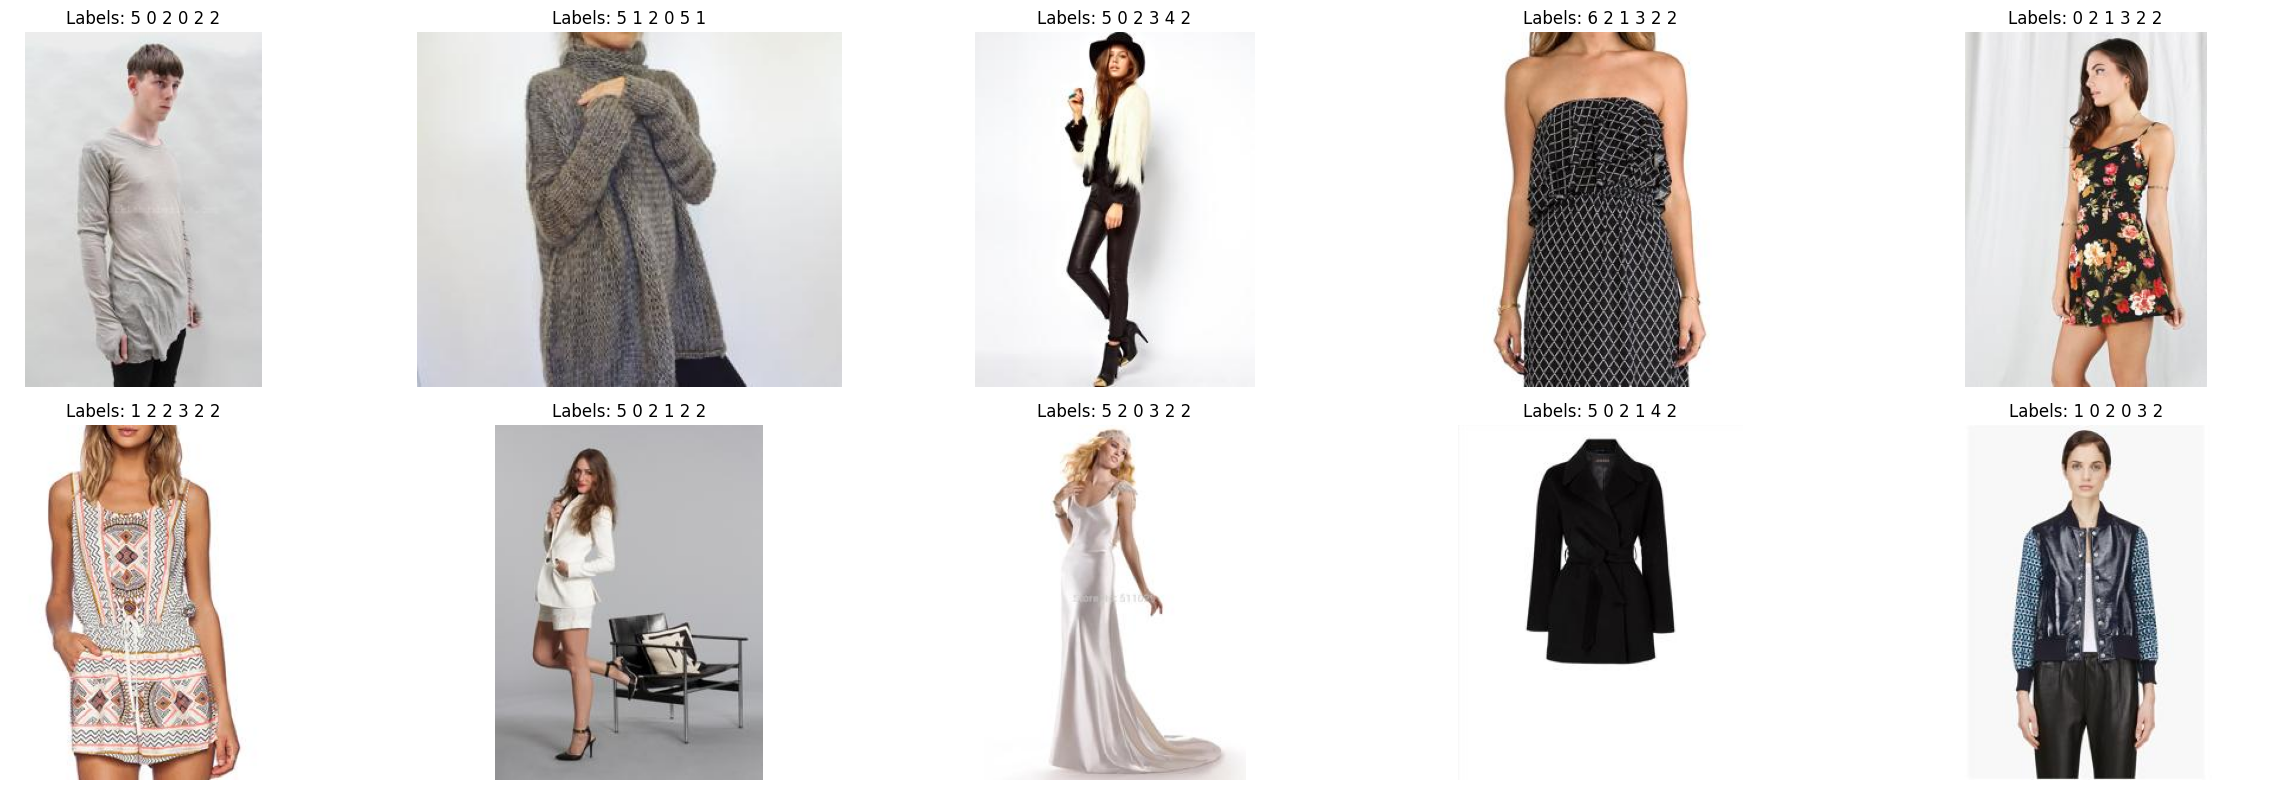

In [7]:
import matplotlib.pyplot as plt

def plot_images_with_labels(dataset, num_images=10):
    # Load the first num_images images and their labels
    images, labels = [], []
    for i in range(num_images):
        img, label = dataset[i]  # img is already a PIL image
        images.append(img)
        labels.append(label.numpy())  # Convert labels to numpy array for easy manipulation

    # Plotting
    rows = 2
    cols = num_images // rows
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))  # Adjust size accordingly
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axs[i // cols, i % cols]  # Integer division and modulo for 2D indexing
        ax.imshow(img)
        label_str = ' '.join(map(str, lbl))  # Join the label array into a single string
        ax.set_title(f'Labels: {label_str}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function with the dataset
plot_images_with_labels(train_dataset)


<h2 style='color:blue'>Implementation of Pre-trained Model (Resnet50)</h2>

In [8]:
# Model class
# Model class with Dropout
# Add Batch Normalization to the model
class FashionNet(nn.Module):
    def __init__(self, num_classes_list):
        super(FashionNet, self).__init__()
        base_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        num_ftrs = base_model.fc.in_features
        base_model.fc = nn.Identity()
        self.features = nn.Sequential(*list(base_model.children())[:-1],  # Remove original FC
                                      nn.Flatten(),  # Flatten before FC layers
                                      nn.BatchNorm1d(num_ftrs))  # Batch normalization
        self.classifiers = nn.ModuleList()
        for num_classes in num_classes_list:
            classifier = nn.Sequential(
                nn.Dropout(0.5),  # Dropout
                nn.Linear(num_ftrs, 512),
                nn.ReLU(),
                nn.BatchNorm1d(512),  # Additional Batch normalization
                nn.Dropout(0.5),  # Additional Dropout
                nn.Linear(512, num_classes)
            )
            self.classifiers.append(classifier)
    def forward(self, x):
        x = self.features(x)
        outputs = [classifier(x) for classifier in self.classifiers]
        return outputs# Initialize datasets and data loaders


<h2 style='color:blue'>Transformation Part<h2>

In [9]:
# Transformation Part
# Applying more aggressive data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = FashionNetDataset(root=root_dir, txt=train_dir, transform=train_transform)
val_dataset = FashionNetDataset(root=root_dir, txt=val_dir, transform=val_transform)
test_dataset = FashionNetDataset(root=root_dir, txt=test_dir, transform=val_transform, test=True)

sample_weights = train_dataset.get_class_weights()

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Processed 5000 images.
Processed 1000 images.
Processed 1000 images.


<h2 style='color:blue'>Plot Images After Transformation</h2>

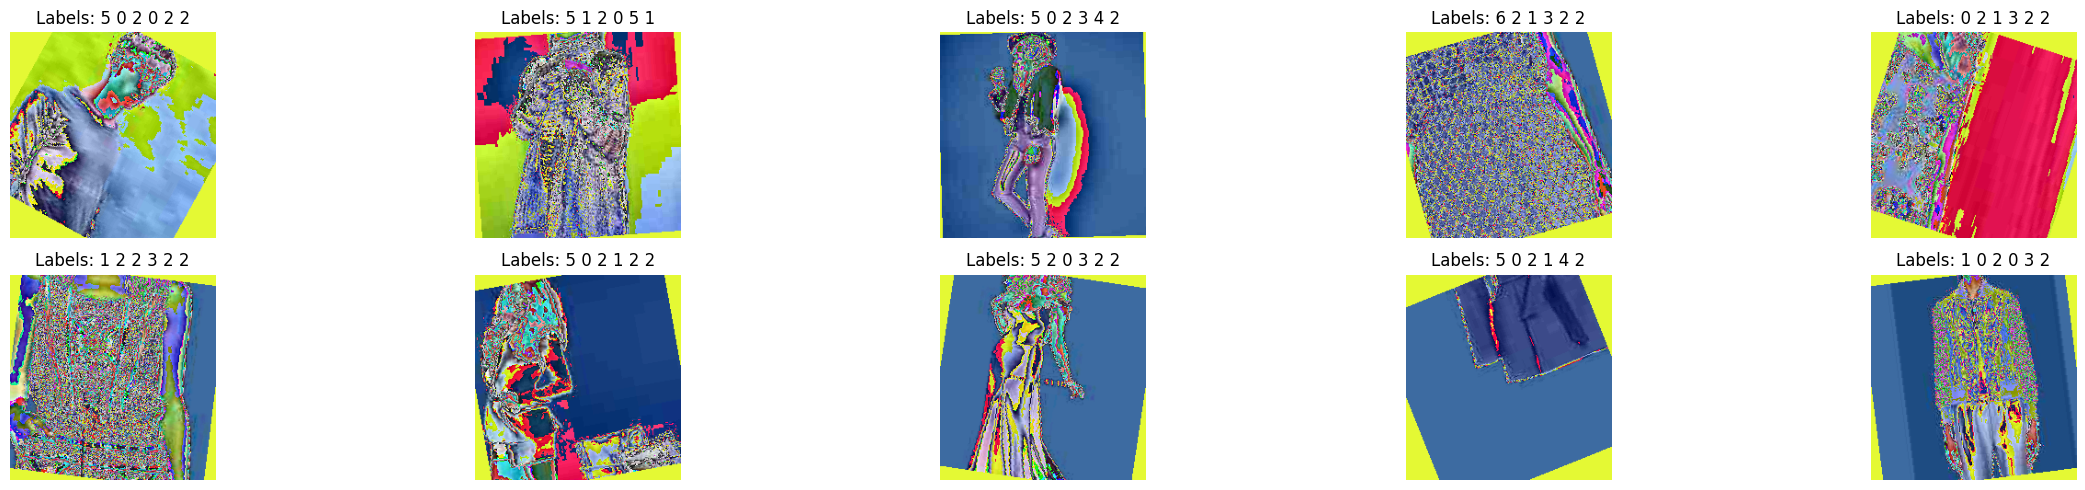

In [10]:
# Plot after Transformation
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def plot_images_with_labels(dataset, num_images=10):
    # Load the first num_images images and their labels
    images, labels = [], []
    for i in range(num_images):
        img, label = dataset[i]  # Ensure that train_dataset is loaded correctly
        images.append(TF.to_pil_image(img))
        labels.append(label.numpy())  # Convert labels to numpy array for easy manipulation

    # Plotting
    rows = 2
    cols = num_images // rows
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 2.5 * rows))  # Adjust size accordingly
    for i, (img, lbl) in enumerate(zip(images, labels)):
        ax = axs[i // cols, i % cols]  # Integer division and modulo for 2D indexing
        ax.imshow(img)
        label_str = ' '.join(map(str, lbl))  # Join the label array into a single string
        ax.set_title(f'Labels: {label_str}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()


plot_images_with_labels(train_dataset)


<h2 style='color:blue'>compute_avg_class_accuracy,train_any_epoch,validate_model Methods</h2>

In [38]:

def compute_avg_class_accuracy(correct_predictions, total_predictions):
    """
    Computes the average class accuracy.

    correct_predictions: List of lists, where each sublist contains correct prediction counts per class for each attribute.
    total_predictions: List of lists, where each sublist contains total prediction counts per class for each attribute.
    """
    avg_class_acc = []
    num_attr = len(correct_predictions)  # Assuming the outer list is per attribute

    for attr_idx in range(num_attr):
        attr_correct = correct_predictions[attr_idx]
        attr_total = total_predictions[attr_idx]
        class_acc = [100.0 * attr_correct[class_idx] / attr_total[class_idx] if attr_total[class_idx] > 0 else 0 for class_idx in range(len(attr_correct))]

        avg_class_acc.extend(class_acc)

    return np.mean(avg_class_acc) if avg_class_acc else 0
def train_any_epoch(model, train_loader, optimizer, sample_weights):
    model.train()
    running_loss = 0.0
    correct_predictions = [[0 for _ in range(num_classes[i])] for i in range(NUM_ATTR)]
    total_predictions = [[0 for _ in range(num_classes[i])] for i in range(NUM_ATTR)]

    # Initialize containers for precision, recall, and F1-score calculations
    all_labels = [[] for _ in range(NUM_ATTR)]
    all_predictions = [[] for _ in range(NUM_ATTR)]

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = sum(nn.CrossEntropyLoss(weight=sample_weights[i].to(device))(outputs[i], labels[:, i]) for i in range(len(outputs)))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        for i in range(len(outputs)):
            _, predicted = torch.max(outputs[i].data, 1)
            all_labels[i].extend(labels[:, i].cpu().numpy())
            all_predictions[i].extend(predicted.cpu().numpy())
            for j in range(labels.size(0)):
                total_predictions[i][labels[j, i].item()] += 1
                if predicted[j] == labels[j, i]:
                    correct_predictions[i][labels[j, i].item()] += 1

    epoch_loss = running_loss / len(train_loader)
    total_correct = sum([sum(attr) for attr in correct_predictions])
    total_pred = sum([sum(attr) for attr in total_predictions])
    epoch_acc = (total_correct / total_pred * 100) if total_pred > 0 else 0
    avg_class_acc = compute_avg_class_accuracy(correct_predictions, total_predictions)

    # Calculate precision, recall, and F1
    precision_scores = [precision_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    recall_scores = [recall_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    f1_scores = [f1_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    avg_precision = sum(precision_scores) / NUM_ATTR
    avg_recall = sum(recall_scores) / NUM_ATTR
    avg_f1 = sum(f1_scores) / NUM_ATTR

    # Fix to return statement to include all necessary metrics
    return epoch_loss, epoch_acc, avg_class_acc, correct_predictions, total_predictions, avg_precision, avg_recall, avg_f1

def validate_model(model, val_loader, sample_weights):
    model.eval()
    running_loss = 0.0
    correct_predictions = [[0 for _ in range(num_classes[i])] for i in range(NUM_ATTR)]
    total_predictions = [[0 for _ in range(num_classes[i])] for i in range(NUM_ATTR)]
    
    # Initialize containers for precision, recall, and F1-score calculations
    all_labels = [[] for _ in range(NUM_ATTR)]
    all_predictions = [[] for _ in range(NUM_ATTR)]
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = sum(nn.CrossEntropyLoss(sample_weights[i].to(device))(outputs[i], labels[:, i]) for i in range(len(outputs)))
            running_loss += loss.item()

            for i in range(len(outputs)):
                _, predicted = torch.max(outputs[i].data, 1)
                all_labels[i].extend(labels[:, i].cpu().numpy())
                all_predictions[i].extend(predicted.cpu().numpy())
                for j in range(labels.size(0)):
                    total_predictions[i][labels[j, i].item()] += 1
                    if predicted[j] == labels[j, i]:
                        correct_predictions[i][labels[j, i].item()] += 1

    avg_loss = running_loss / len(val_loader)
    total_correct = sum([sum(attr) for attr in correct_predictions])
    total_pred = sum([sum(attr) for attr in total_predictions])
    avg_acc = (total_correct / total_pred * 100) if total_pred > 0 else 0
    avg_class_acc = compute_avg_class_accuracy(correct_predictions, total_predictions)
    
    # Calculate precision, recall, and F1-score per attribute, then average across attributes
    precision_scores = [precision_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    recall_scores = [recall_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    f1_scores = [f1_score(all_labels[i], all_predictions[i], average='weighted', zero_division=0) for i in range(NUM_ATTR)]
    avg_precision = sum(precision_scores) / NUM_ATTR
    avg_recall = sum(recall_scores) / NUM_ATTR
    avg_f1 = sum(f1_scores) / NUM_ATTR

    return avg_loss, avg_acc, avg_class_acc, correct_predictions, total_predictions, avg_precision, avg_recall, avg_f1


<h2 style='color:blue'>Accuracies and Loss Plots </h2>

In [39]:
import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_avg_class_accs, val_avg_class_accs, num_epochs):
    # Create a figure with 3 subplots, arranged horizontally
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    epochs = range(1, num_epochs + 1)

    # Plot average loss on the first subplot
    axs[0].plot(epochs, train_losses, 'bo-', label='Training Loss')
    axs[0].plot(epochs, val_losses, 'ro-', label='Validation Loss')
    axs[0].set_title(f'Average Loss for learning rate = {lr}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot average accuracy on the second subplot
    axs[1].plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    axs[1].plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    axs[1].set_title(f'Average Accuracy for learning rate = {lr}')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy (%)')
    axs[1].legend()

    # Plot average per-class accuracy on the third subplot
    axs[2].plot(epochs, train_avg_class_accs, 'bo-', label='Training Avg Class Accuracy')
    axs[2].plot(epochs, val_avg_class_accs, 'ro-', label='Validation Avg Class Accuracy')
    axs[2].set_title(f'Average Per-Class Accuracy for learning rate = {lr}')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy (%)')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

def plot_metrics1(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')

    plt.title(f'Training and Validation Loss for learning rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')

    plt.title(f'Training and Validation Accuracy for learning rate = {lr} ')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_precision_recall_f1_metrics(train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_precisions, 'bo-', label='Training Precision')
    plt.plot(epochs, val_precisions, 'ro-', label='Validation Precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_recalls, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recalls, 'ro-', label='Validation Recall')
    plt.title(f'Training and Validation Recall for learning rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_f1s, 'bo-', label='Training F1 Score')
    plt.plot(epochs, val_f1s, 'ro-', label='Validation F1 Score')
    plt.title(f'Training and Validation F1 Score for learning rate = {lr}')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.show()



<h2 style='color:blue'> Call all above tasks in main() and see the all needed results</h2>

Processed 5000 images.

Processed 1000 images.

Processed 1000 images.

Epoch 1/50, lr: 0.0001 Train Loss: 8.8142, Train Acc: 30.92%, Train Avg Class Acc: 30.76%, Val Loss: 6.9767, Val Acc: 43.60%, Val Avg Class Acc: 47.44%,Training completed in 52.90 seconds.

New best model saved.

Epoch 2/50, lr: 0.0001 Train Loss: 7.6940, Train Acc: 38.39%, Train Avg Class Acc: 42.25%, Val Loss: 6.2599, Val Acc: 48.50%, Val Avg Class Acc: 54.30%,Training completed in 105.55 seconds.

New best model saved.

Epoch 3/50, lr: 0.0001 Train Loss: 6.9505, Train Acc: 42.86%, Train Avg Class Acc: 50.23%, Val Loss: 5.8416, Val Acc: 50.77%, Val Avg Class Acc: 57.15%,Training completed in 158.00 seconds.

New best model saved.

Epoch 4/50, lr: 0.0001 Train Loss: 6.5409, Train Acc: 46.07%, Train Avg Class Acc: 54.44%, Val Loss: 5.6681, Val Acc: 53.00%, Val Avg Class Acc: 59.29%,Training completed in 210.32 seconds.

New best model saved.

Epoch 5/50, lr: 0.0001 Train Loss: 6.3380, Train Acc: 48.16%, Train Avg C

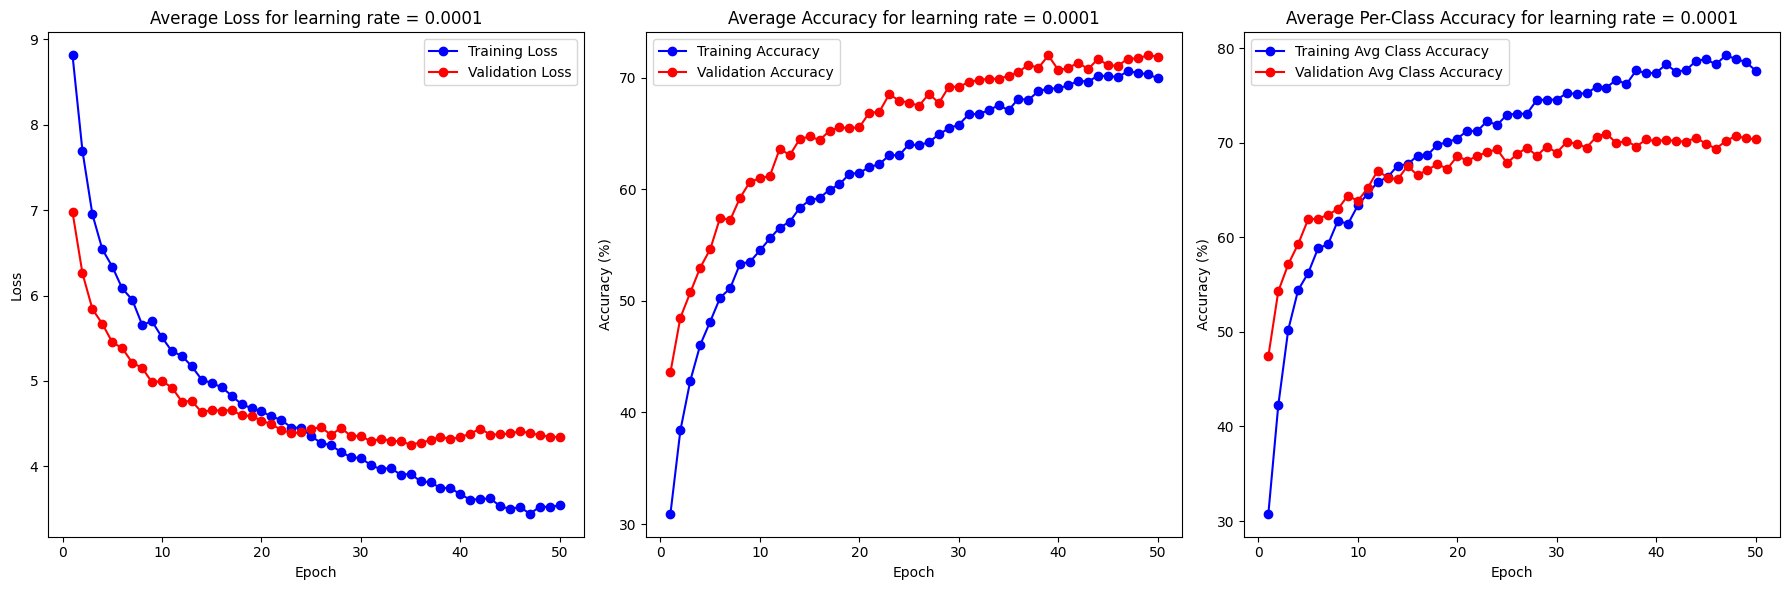

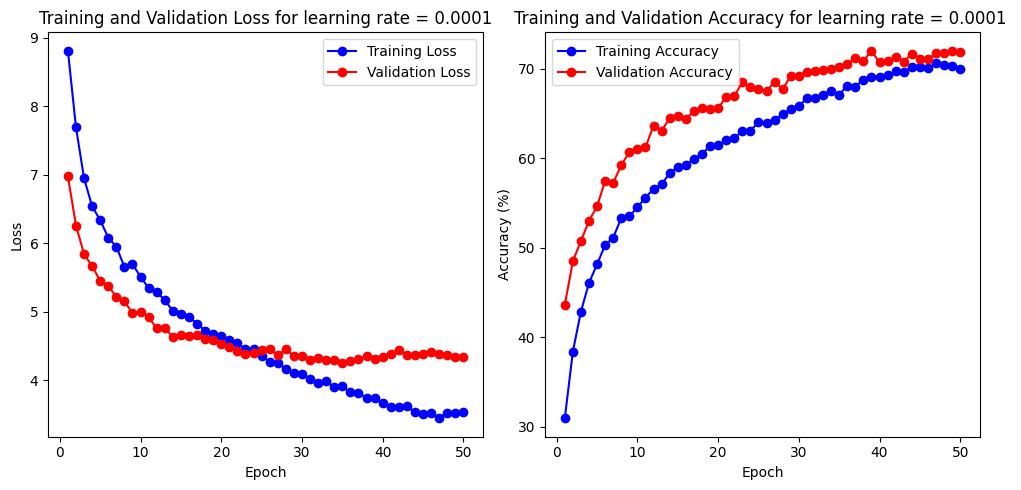

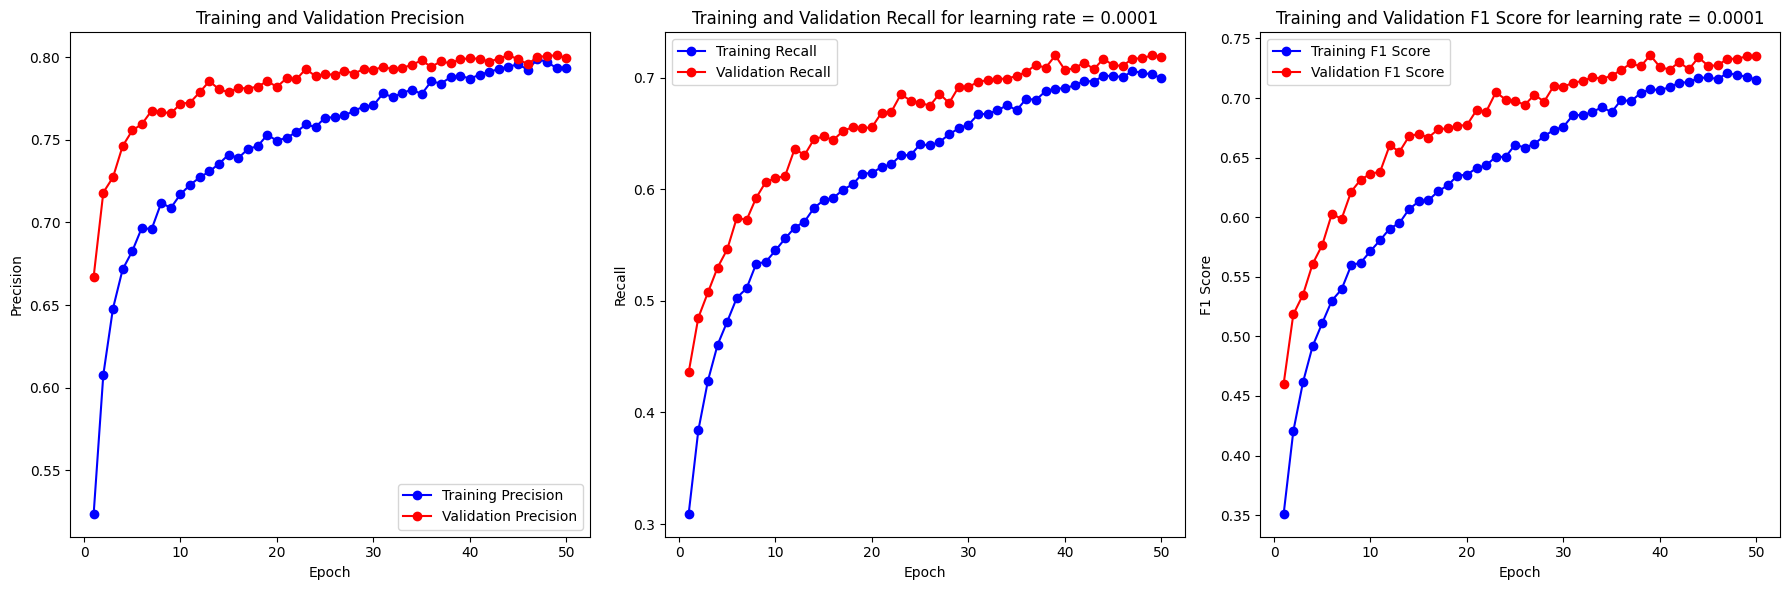

In [42]:
import time
def main():
    start_time = time.time()  # Start time measurement
    num_epochs = 50
    global best_val_acc  # Use global variable for best validation accuracy
    best_val_acc = -float('inf')  # Initialize best validation accuracy to negative infinity

    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_avg_class_accs = []
    val_avg_class_accs = []
    
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_f1s = []
    val_f1s = []

    # Load datasets
    train_dataset = FashionNetDataset(root=root_dir, txt=train_dir, transform=train_transform)
    val_dataset = FashionNetDataset(root=root_dir, txt=val_dir, transform=val_transform)
    test_dataset = FashionNetDataset(root=root_dir, txt=test_dir, transform=val_transform, test=True)

    # Prepare data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize the model, criterion, optimizer, and scheduler
    model = FashionNet(num_classes_list=num_classes).to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5)

    # Training and validation loop
    for epoch in range(num_epochs):
        train_loss, train_acc, train_avg_class_acc, _, _, train_precision, train_recall, train_f1 = train_any_epoch(model, train_loader, optimizer, sample_weights)
        val_loss, val_acc, val_avg_class_acc, _, _, val_precision, val_recall, val_f1 = validate_model(model, val_loader, sample_weights)
        elapsed_time = time.time() - start_time  # Calculate elapsed time
        # Append metrics to the lists for plotting
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        train_avg_class_accs.append(train_avg_class_acc)
        val_avg_class_accs.append(val_avg_class_acc)
        train_precisions.append(train_precision)
        val_precisions.append(val_precision)
        train_recalls.append(train_recall)
        val_recalls.append(val_recall)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}/{num_epochs}, lr: {lr} Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Train Avg Class Acc: {train_avg_class_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val Avg Class Acc: {val_avg_class_acc:.2f}%,Training completed in {elapsed_time:.2f} seconds.")

        # Save the best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = "best_model.pth"
            torch.save(model.state_dict(), best_model_path)
            print("New best model saved.")

        # Adjust learning rate based on the validation loss
        scheduler.step(val_loss)

    print("Training completed.")
    return train_losses, val_losses, train_accuracies, val_accuracies, train_avg_class_accs, val_avg_class_accs, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s, epoch + 1

if __name__ == "__main__":
    results = main()
    train_losses, val_losses, train_accuracies, val_accuracies, train_avg_class_accs, val_avg_class_accs, train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s, num_epochs = results
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, train_avg_class_accs, val_avg_class_accs, num_epochs)
    plot_metrics1(train_losses, val_losses, train_accuracies, val_accuracies)
    plot_precision_recall_f1_metrics(train_precisions, val_precisions, train_recalls, val_recalls, train_f1s, val_f1s, num_epochs)


<h2 style='color:blue'> Create Prediction file</h2>

In [43]:
import zipfile

model = FashionNet(num_classes_list=num_classes).to(device)
# Load your model
model_path = '/kaggle/working/best_model.pth'  # Ensure this is the correct path
try:
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading the model: {e}")

model.eval()


# Prediction generation
all_predictions = []

with torch.no_grad():
    for images, _ in test_loader:  # Use a placeholder to ignore the dummy labels
        images = images.to(device)
        outputs = model(images)

        # Convert model outputs to predicted classes
        predicted_classes = [torch.argmax(output, dim=1) for output in outputs]
        predicted_classes = torch.stack(predicted_classes, dim=1)
        all_predictions.extend(predicted_classes.cpu().numpy())



# Save predictions to a file
prediction_file_path = './prediction.txt'
with open(prediction_file_path, 'w') as f:
    for preds in all_predictions:
        prediction_line = ' '.join(map(str, preds.tolist())) + '\n'
        f.write(prediction_line)

# Optional: Create a zip file for submission
zipfile_path = 'prediction.zip'
with zipfile.ZipFile(zipfile_path, 'w') as zipf:
    zipf.write(prediction_file_path, arcname='prediction.txt')

print("Finished generating and saving predictions.")

Model loaded successfully.

Finished generating and saving predictions.



<h1 style='color:blue'> <center>Number of Parameters</center></h1>

In [44]:
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
num_parameters

29826138

<h1 style='color:blue'> <center>Specifications of my training machine</center></h1>

In [2]:
# To get GPU information (using the nvidia-smi command which is available on systems with NVIDIA GPUs)
!nvidia-smi



Thu Mar 21 21:26:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0              27W / 250W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

<h1 style='color:blue'> <center>End of project</center></h1>